# 1 - Import Libraries

In [1]:
# Downgrade version of TensorFlow and tf-keras

!pip install -q --upgrade "tensorflow<2.16" "tf-keras<2.16"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.1 MB/s eta 0:00:00


In [2]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version
print(tf.__version__)

2.15.1


# 2 - Data Loading

Source dataset : [URL](https://www.kaggle.com/datasets/noobyogi0100/shoe-dataset)

In [3]:
%%time
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/noobyogi0100/shoe-dataset

!kaggle datasets download -d noobyogi0100/shoe-dataset

Dataset URL: https://www.kaggle.com/datasets/noobyogi0100/shoe-dataset
License(s): CC0-1.0
100% 323M/324M [00:18<00:00, 19.7MB/s]
100% 324M/324M [00:18<00:00, 18.0MB/s]
CPU times: user 271 ms, sys: 23.3 ms, total: 295 ms
Wall time: 21.4 s


In [4]:
# Every dataset that downloaded from Kaggle is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip -qq ./shoe-dataset.zip

In [5]:
# Define path

main_path = '/content/shoeTypeClassifierDataset/'
train_path = os.path.join(main_path, 'training')
test_path = os.path.join(main_path, 'validation')

In [6]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - flip_flops : 249
Total Data - soccer_shoes : 249
Total Data - boots : 249
Total Data - loafers : 249
Total Data - sandals : 249
Total Data - sneakers : 249

Test Path
Total Data - flip_flops : 50
Total Data - soccer_shoes : 50
Total Data - boots : 50
Total Data - loafers : 50
Total Data - sandals : 50
Total Data - sneakers : 50



In [7]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  flip_flops


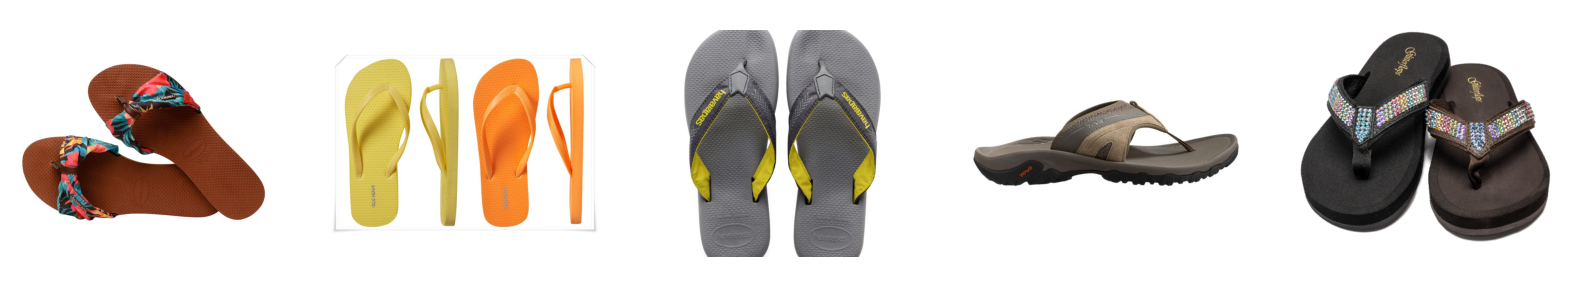

Class :  soccer_shoes


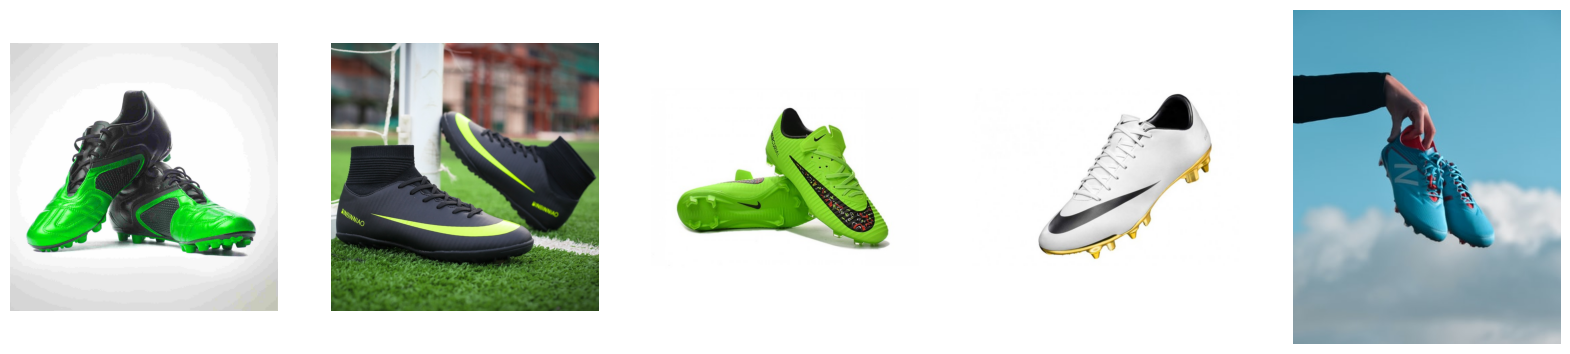

Class :  boots


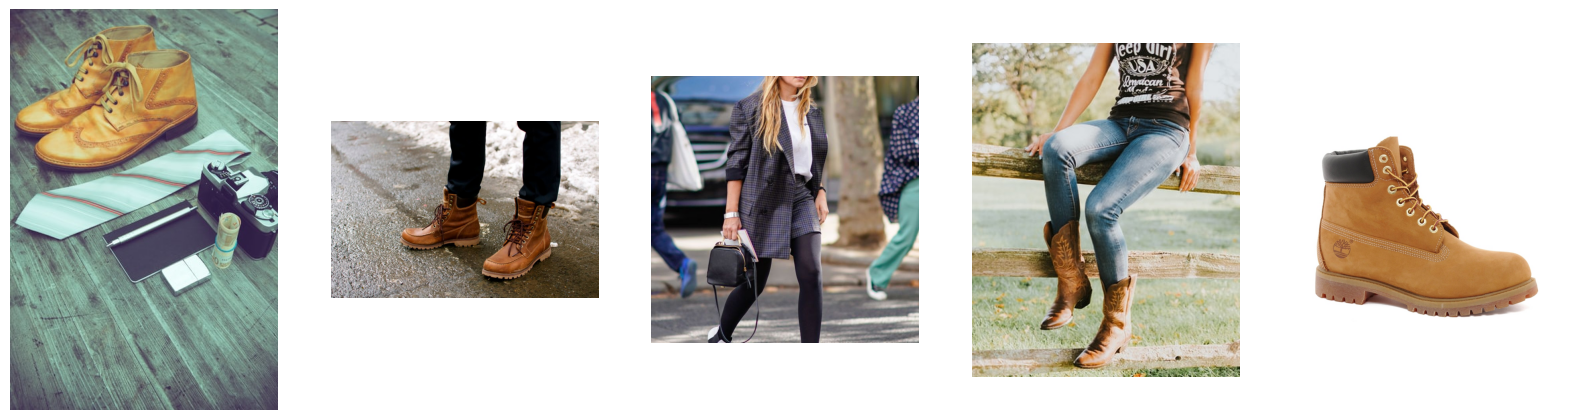

Class :  loafers


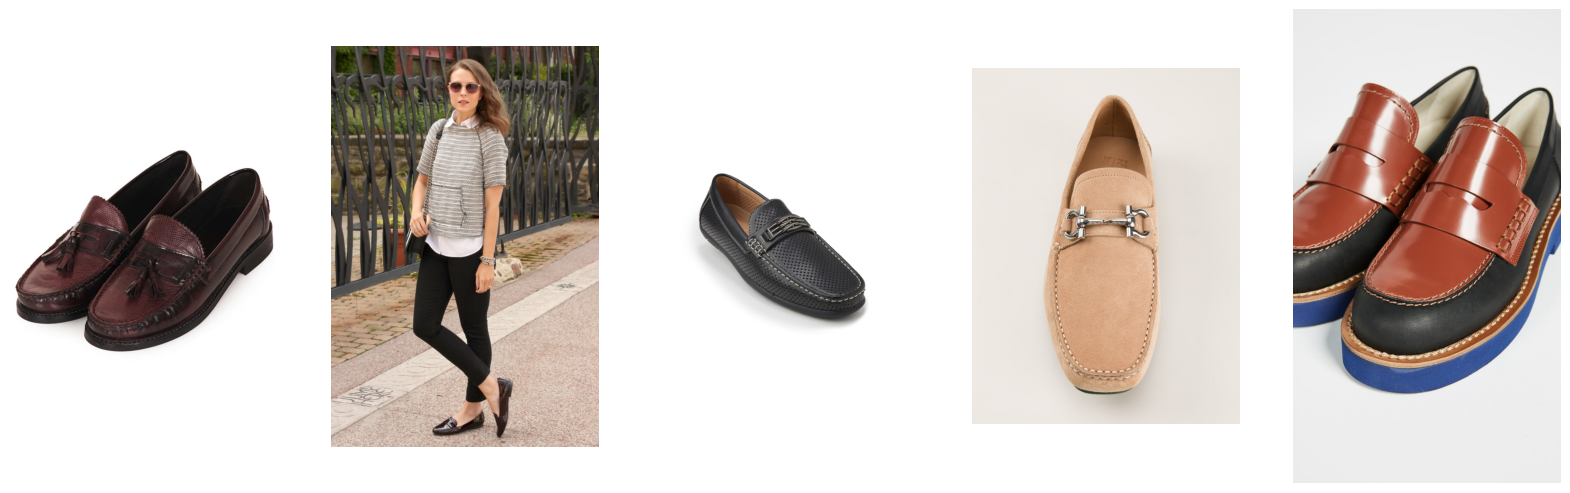

Class :  sandals


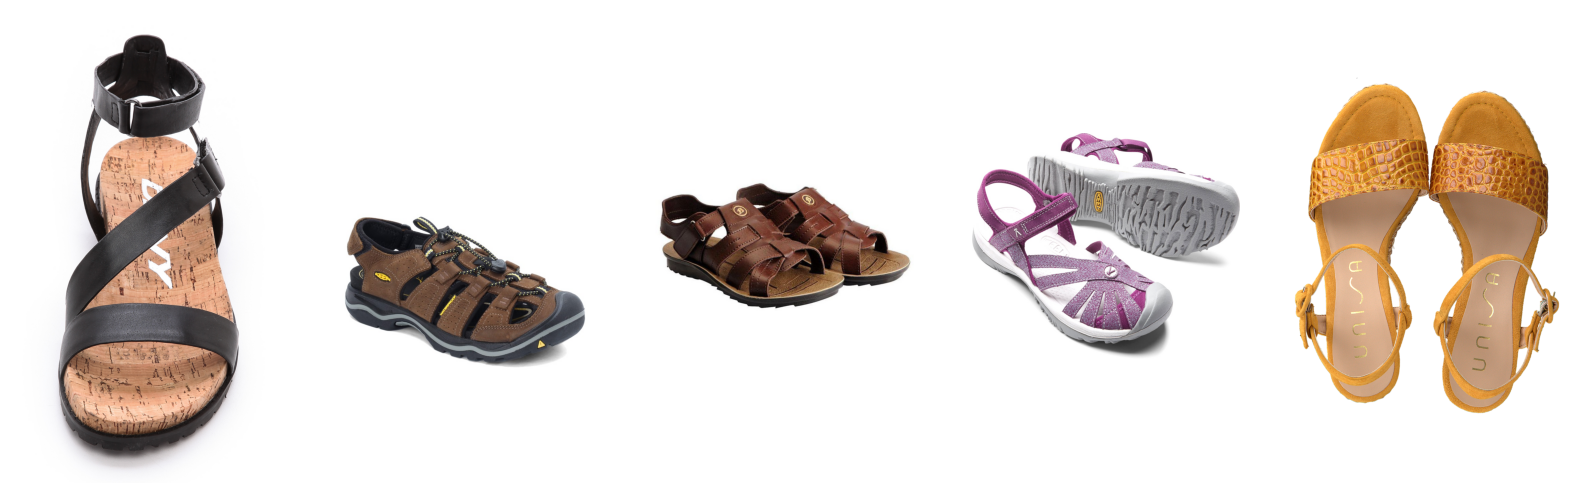

Class :  sneakers


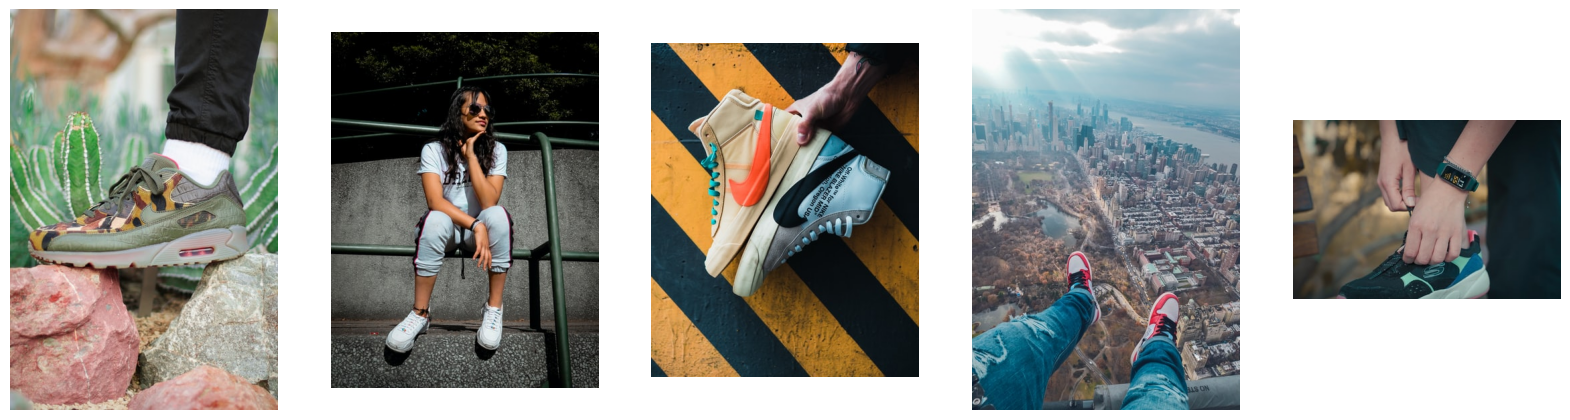

In [8]:
# Visualization of train_path

plot_images(train_path)

Class :  flip_flops


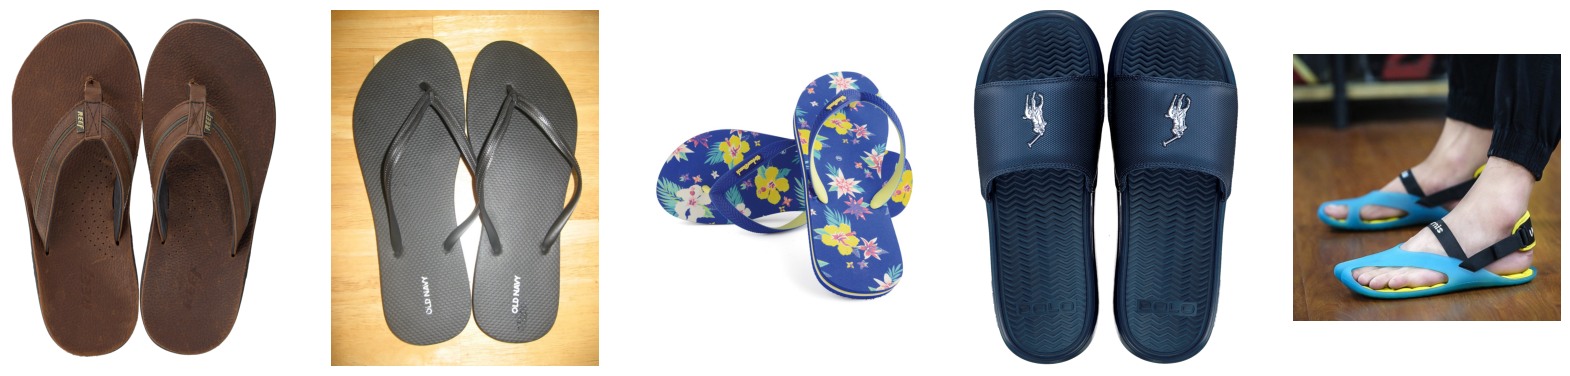

Class :  soccer_shoes


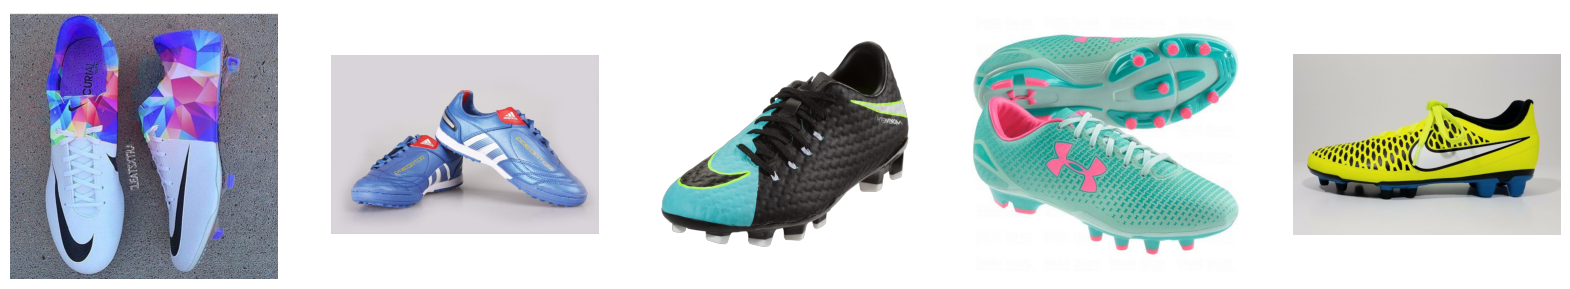

Class :  boots


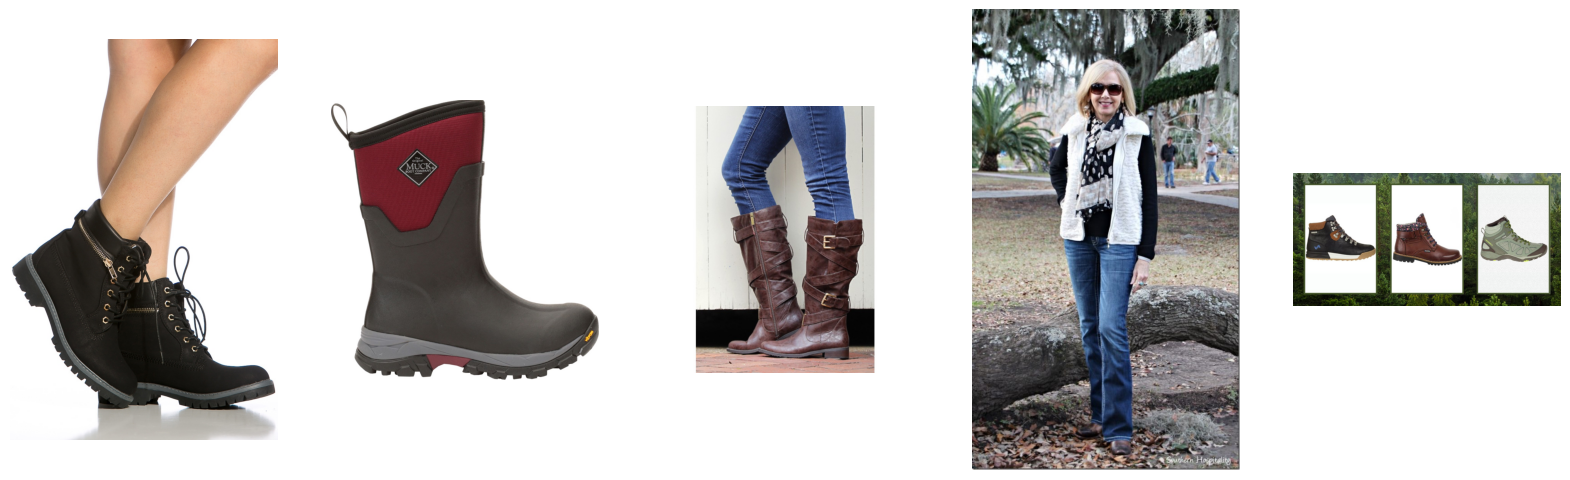

Class :  loafers


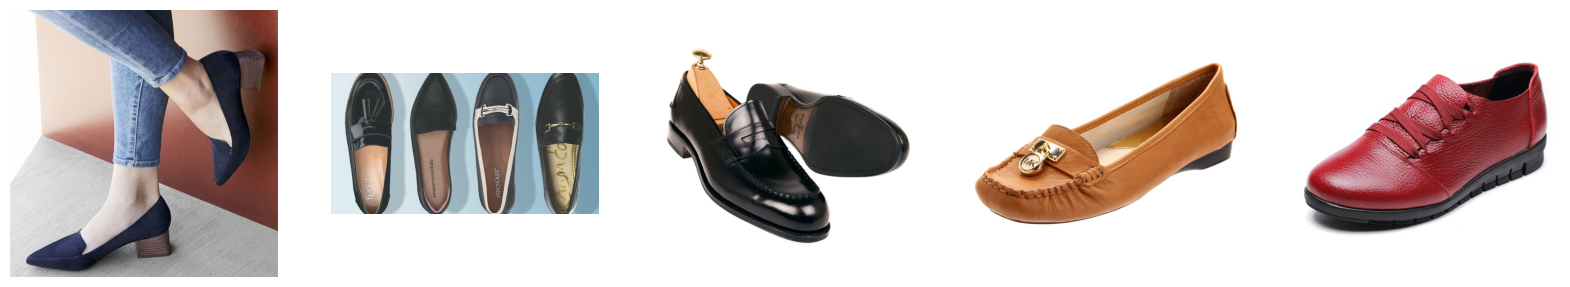

Class :  sandals


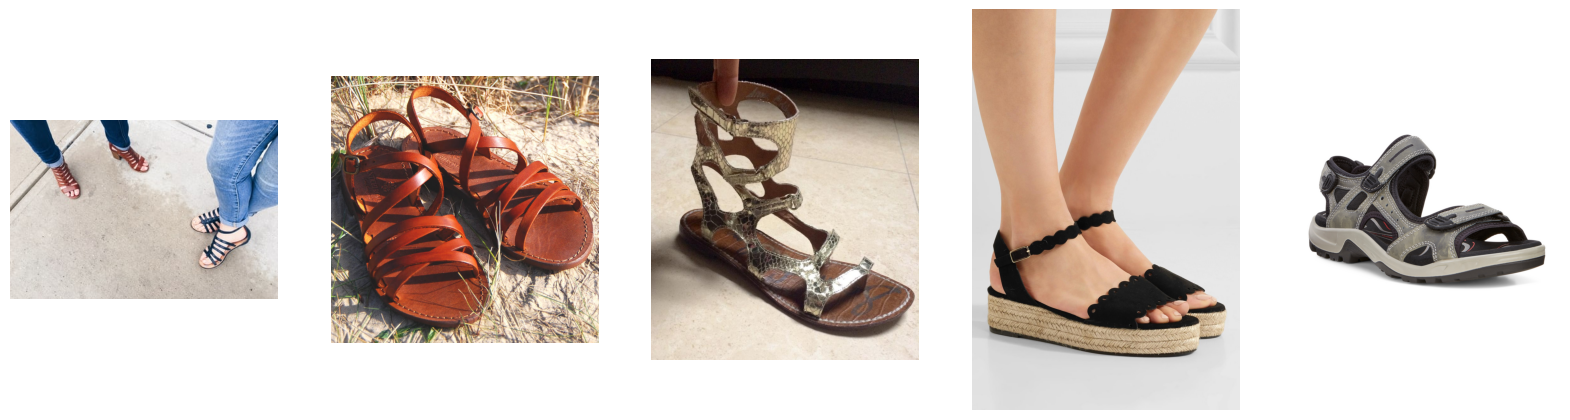

Class :  sneakers


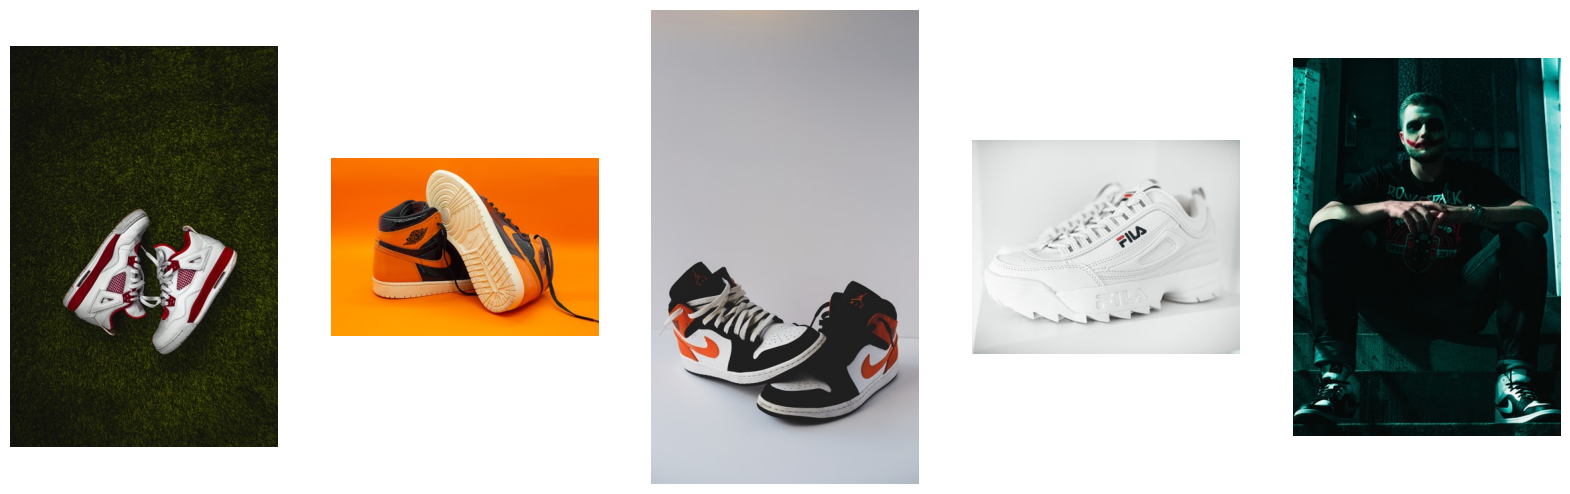

In [9]:
# Visualization of `test_path`

plot_images(test_path)

# 3 - Modeling without Data Augmentation

## 3.1 - Preprocessing

In [10]:
# Define hyperparameters

img_height= 220
img_width= 220
batch_size= 64

In [11]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 899 images belonging to 6 classes.
Found 594 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [12]:
# Show labels

train_set.class_indices

{'boots': 0,
 'flip_flops': 1,
 'loafers': 2,
 'sandals': 3,
 'sneakers': 4,
 'soccer_shoes': 5}

## 3.2 - Model Definition

In [13]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [14]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 128)       0

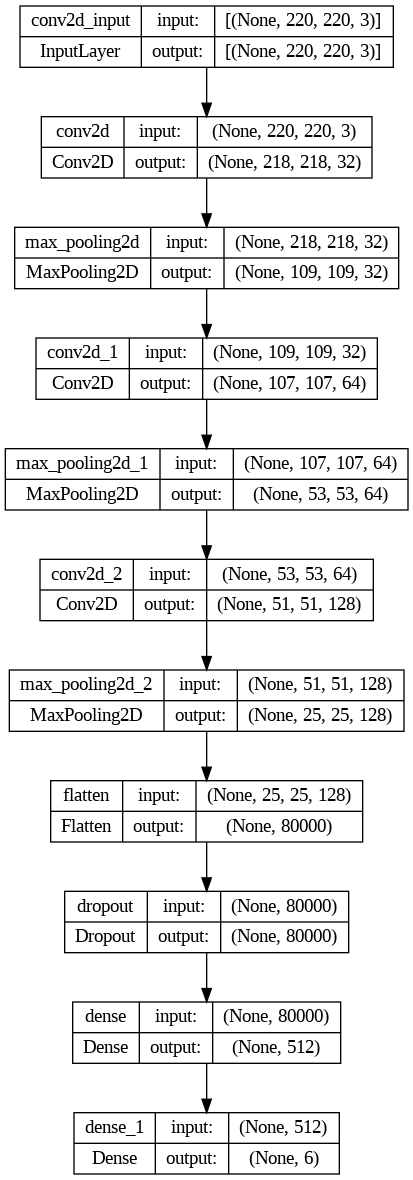

In [15]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## 3.3 - Model Training

In [16]:
# Train the model

%%time
history = model.fit(train_set, epochs=10, validation_data=val_set, batch_size=batch_size)

Epoch 1/10
15/15 [==============================] - 28s 1s/step - loss: 2.8317 - accuracy: 0.1880 - val_loss: 1.7899 - val_accuracy: 0.1667
Epoch 2/10
15/15 [==============================] - 19s 1s/step - loss: 1.7515 - accuracy: 0.2314 - val_loss: 1.6844 - val_accuracy: 0.2795
Epoch 3/10
15/15 [==============================] - 19s 1s/step - loss: 1.6550 - accuracy: 0.3326 - val_loss: 1.6528 - val_accuracy: 0.3519
Epoch 4/10
15/15 [==============================] - 22s 2s/step - loss: 1.5131 - accuracy: 0.4194 - val_loss: 1.5872 - val_accuracy: 0.3603
Epoch 5/10
15/15 [==============================] - 18s 1s/step - loss: 1.3221 - accuracy: 0.5072 - val_loss: 1.5548 - val_accuracy: 0.3687
Epoch 6/10
15/15 [==============================] - 19s 1s/step - loss: 1.2172 - accuracy: 0.5717 - val_loss: 1.5728 - val_accuracy: 0.3990
Epoch 7/10
15/15 [==============================] - 18s 1s/step - loss: 0.9662 - accuracy: 0.6496 - val_loss: 1.5803 - val_accuracy: 0.4158
Epoch 8/10
15/15 [==

## 3.4 - Model Evaluation

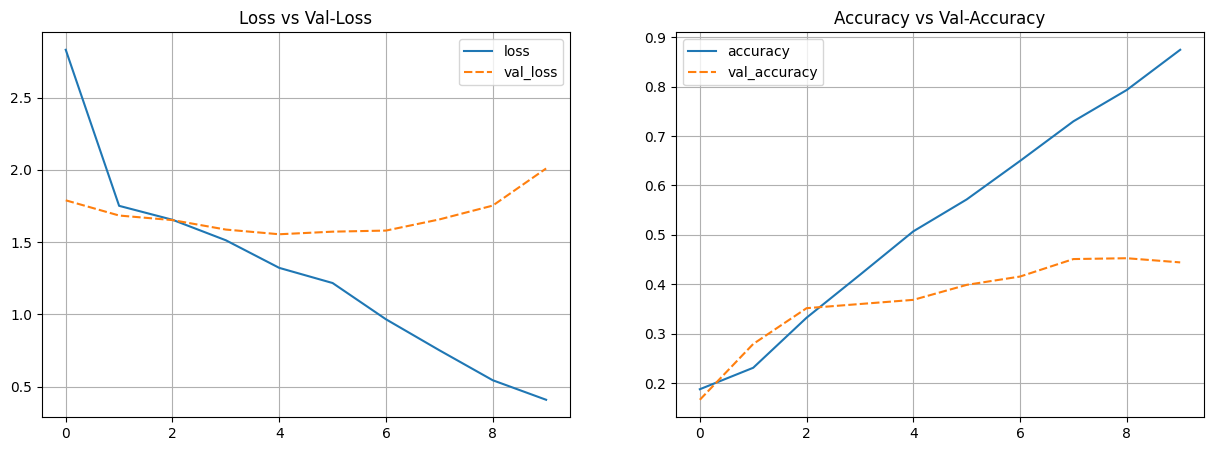

In [17]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [18]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

       boots       0.46      0.48      0.47        50
  flip_flops       0.44      0.72      0.55        50
     loafers       0.56      0.46      0.51        50
     sandals       0.24      0.30      0.27        50
    sneakers       0.64      0.46      0.53        50
soccer_shoes       0.50      0.28      0.36        50

    accuracy                           0.45       300
   macro avg       0.47      0.45      0.45       300
weighted avg       0.47      0.45      0.45       300



# 4 - Modeling with Data Augmentation

## 4.1 - Preprocessing

In [19]:
# Define hyperparameters

img_height= 220
img_width= 220
batch_size= 64

In [20]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    rotation_range=20,
                                                                    zoom_range=0.05,
                                                                    width_shift_range=0.05,
                                                                    height_shift_range=0.05,
                                                                    shear_range=0.05,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 899 images belonging to 6 classes.
Found 594 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


## 4.2 - Model Definition

In [21]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [22]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(6, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 128)       0

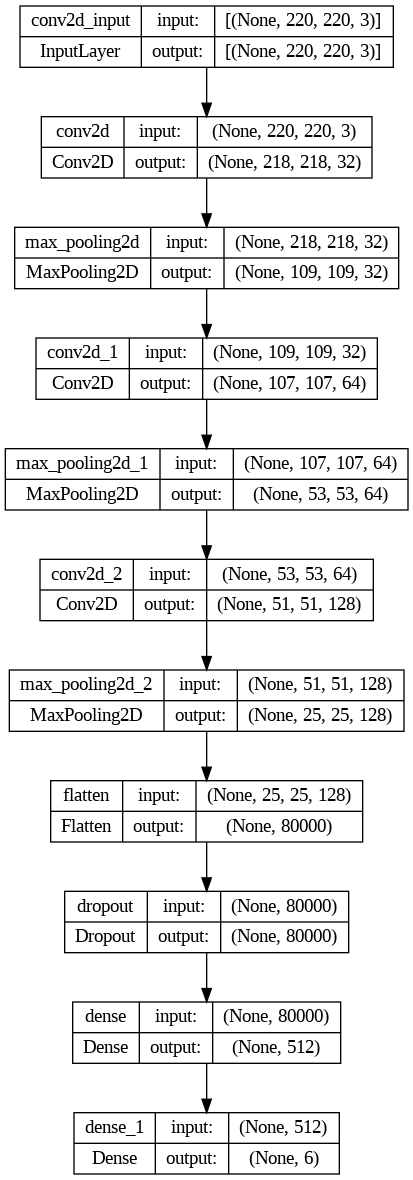

In [23]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## 4.3 - Model Training

In [24]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=10, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/10
15/15 [==============================] - 44s 3s/step - loss: 2.8367 - accuracy: 0.1880 - val_loss: 1.7811 - val_accuracy: 0.1936
Epoch 2/10
15/15 [==============================] - 35s 2s/step - loss: 1.7761 - accuracy: 0.2236 - val_loss: 1.7351 - val_accuracy: 0.2340
Epoch 3/10
15/15 [==============================] - 32s 2s/step - loss: 1.7257 - accuracy: 0.2558 - val_loss: 1.6777 - val_accuracy: 0.2997
Epoch 4/10
15/15 [==============================] - 34s 2s/step - loss: 1.6621 - accuracy: 0.2725 - val_loss: 1.6303 - val_accuracy: 0.3266
Epoch 5/10
15/15 [==============================] - 32s 2s/step - loss: 1.6228 - accuracy: 0.3415 - val_loss: 1.6203 - val_accuracy: 0.3148
Epoch 6/10
15/15 [==============================] - 33s 2s/step - loss: 1.5876 - accuracy: 0.3237 - val_loss: 1.5803 - val_accuracy: 0.3552
Epoch 7/10
15/15 [==============================] - 32s 2s/step - loss: 1.5048 - accuracy: 0.3882 - val_loss: 1.5179 - val_accuracy: 0.3771
Epoch 8/10
15/15 [==

## 4.4 - Model Evaluation

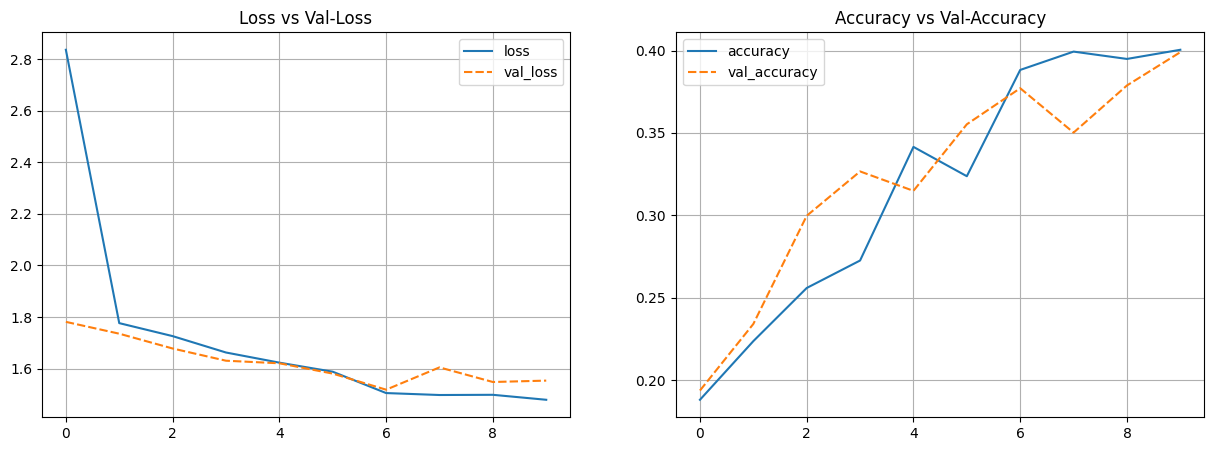

In [25]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [26]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

       boots       0.56      0.36      0.44        50
  flip_flops       0.31      0.56      0.40        50
     loafers       0.35      0.40      0.37        50
     sandals       0.50      0.06      0.11        50
    sneakers       0.44      0.78      0.56        50
soccer_shoes       0.67      0.36      0.47        50

    accuracy                           0.42       300
   macro avg       0.47      0.42      0.39       300
weighted avg       0.47      0.42      0.39       300



# 5 - Transfer Learning

For last scenario, we will implement Transfer Learning. Transfer learning is a technique where a model trained on one task or dataset is adapted and fine-tuned for a different but related task or dataset. It leverages knowledge gained from the source task to improve performance on the target task.

Please see this [source](https://keras.io/api/applications/) or [source](https://www.tensorflow.org/api_docs/python/tf/keras/applications/) for more details.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:png/1*gw37manvc-f9xuFXx9_8WA.png'>

**Notes of VGG-16:**

1. The default input size for this model is 224x224.

2. Each Keras Application expects a specific kind of input preprocessing. For VGG16, call `keras.applications.vgg16.preprocess_input` on your inputs before passing them to the model. `vgg16.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

[Source](https://keras.io/api/applications/vgg/#vgg16-function)

## 5.1 - Preprocessing

In [27]:
# Define hyperparameters

img_height= 224
img_width= 224
batch_size= 64

In [28]:
# Download pretrained model

from keras.applications.vgg16 import VGG16, preprocess_input

pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [29]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   zoom_range=0.05,
                                                                   width_shift_range=0.05,
                                                                   height_shift_range=0.05,
                                                                   shear_range=0.05,
                                                                   horizontal_flip=True,
                                                                   validation_split=0.4,
                                                                   preprocessing_function=preprocess_input)

train_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

val_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl = test_datagen_tl.flow_from_directory(test_path,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=2)

Found 899 images belonging to 6 classes.
Found 594 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


## 5.2 - Model Definition

In [30]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [31]:
# Create Sequential API model

model_tl = Sequential()
model_tl.add(pretrained_model)

model_tl.add(Flatten())
model_tl.add(Dense(512, activation='relu'))
model_tl.add(Dense(6, activation='softmax'))

# Compile
model_tl.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27563334 (105.15 MB)
Trainable params: 12848646 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


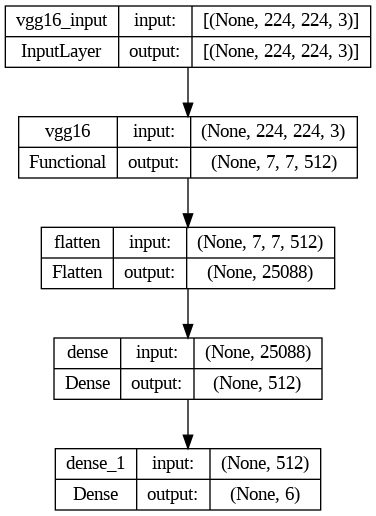

In [32]:
# Plot layers

tf.keras.utils.plot_model(model_tl, show_shapes=True)

## 5.3 - Model Training

In [33]:
# Train the model

%%time
history_tl = model_tl.fit(train_set_tl, epochs=10, validation_data=val_set_tl, batch_size=batch_size)

Epoch 1/10
15/15 [==============================] - 52s 3s/step - loss: 56.4653 - accuracy: 0.3749 - val_loss: 6.1521 - val_accuracy: 0.4747
Epoch 2/10
15/15 [==============================] - 35s 2s/step - loss: 2.4638 - accuracy: 0.6663 - val_loss: 1.7451 - val_accuracy: 0.5842
Epoch 3/10
15/15 [==============================] - 41s 3s/step - loss: 0.7742 - accuracy: 0.7364 - val_loss: 1.1863 - val_accuracy: 0.6330
Epoch 4/10
15/15 [==============================] - 36s 2s/step - loss: 0.4746 - accuracy: 0.8309 - val_loss: 1.2066 - val_accuracy: 0.6700
Epoch 5/10
15/15 [==============================] - 34s 2s/step - loss: 0.3955 - accuracy: 0.8521 - val_loss: 1.4410 - val_accuracy: 0.6902
Epoch 6/10
15/15 [==============================] - 41s 3s/step - loss: 0.2787 - accuracy: 0.8988 - val_loss: 1.2206 - val_accuracy: 0.6919
Epoch 7/10
15/15 [==============================] - 35s 2s/step - loss: 0.2448 - accuracy: 0.9143 - val_loss: 1.2027 - val_accuracy: 0.7239
Epoch 8/10
15/15 [=

## 5.4 - Model Evaluation

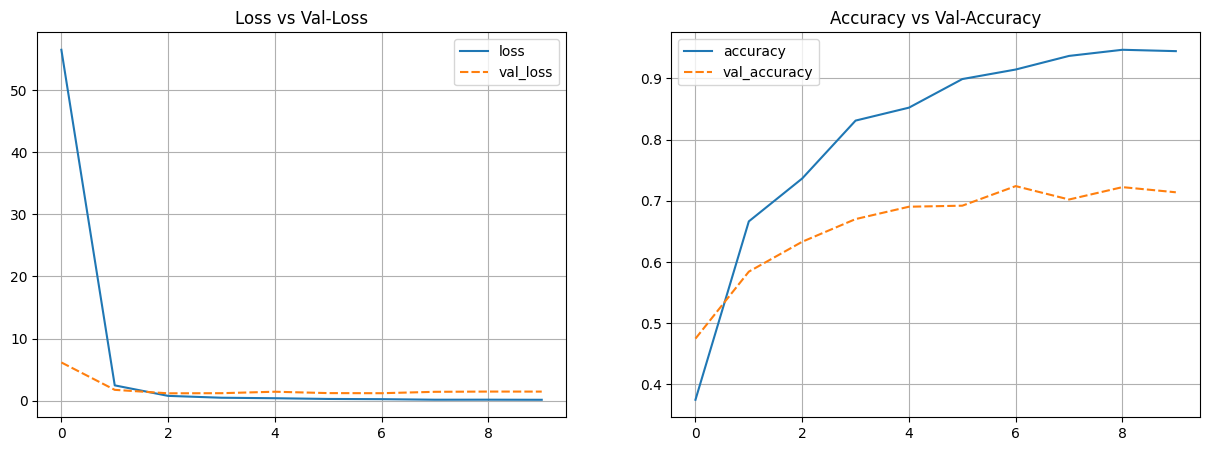

In [34]:
# Plot training results

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [35]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl = model_tl.predict_generator(test_set_tl)

## Get class with maximum probability
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

## Display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

              precision    recall  f1-score   support

       boots       0.95      0.76      0.84        50
  flip_flops       0.68      0.86      0.76        50
     loafers       0.88      0.74      0.80        50
     sandals       0.60      0.54      0.57        50
    sneakers       0.72      0.72      0.72        50
soccer_shoes       0.73      0.88      0.80        50

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300

